Number of qtl colocalized sets when 1 gene at a time, all v39 genes, or all genes

In [5]:
import pandas as pd
import glob
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import os


In [19]:
gencode_ids = pd.read_table("/home/klawren/oak/gtex/data//other_references/gencode/gencode_id_matching.txt")

/local/scratch/klawren/slrmtmp.48890488/ipykernel_13215/3309217102.py:1: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode_ids = pd.read_table("/home/klawren/oak/gtex/data//other_references/gencode/gencode_id_matching.txt")


In [6]:
tissue_id = "Adrenal_Gland"
coloc_output_dir = f"/home/klawren/oak/gtex/output/coloc_qtl_only/{tissue_id}"
aggregated_output_dir = "/home/klawren/oak/gtex/output/coloc_qtl_only"

In [7]:


def read_and_tag_generator(files, desc=None):
    """
    Generator to read files and add a source_file column, yielding DataFrames.
    Shows a tqdm progress bar.
    """
    for f in tqdm(files, desc=desc):
        df = pd.read_table(f)
        df['source_file'] = f
        yield df

# Find all .xqtl_coloc.txt files in the coloc_output_dir
coloc_files = glob.glob(f"{coloc_output_dir}/*.xqtl_coloc.txt")

# Split files by type using list comprehensions
v39_files = [f for f in coloc_files if "v39_genes" in f]
all_files = [f for f in coloc_files if "all_genes" in f]

# Concatenate using generator to avoid loading all files at once into memory, with progress bars
v39_coloc_df = pd.concat(read_and_tag_generator(v39_files, desc="Reading v39 files"), ignore_index=True)
all_coloc_df = pd.concat(read_and_tag_generator(all_files, desc="Reading all genes files"), ignore_index=True)

# For individual gene files, use the same approach
individual_coloc_files = glob.glob(f"{coloc_output_dir}/individual_genes/*.xqtl_coloc.txt")
individual_coloc_df = pd.concat(read_and_tag_generator(individual_coloc_files, desc="Reading individual gene files"), ignore_index=True)

# write out aggregated coloc files
os.makedirs(aggregated_output_dir, exist_ok=True)
individual_coloc_df.to_csv(f"{aggregated_output_dir}/{tissue_id}.xqtl_coloc.individual.txt", sep="\t", index=False)
v39_coloc_df.to_csv(f"{aggregated_output_dir}/{tissue_id}.xqtl_coloc.v39.txt", sep="\t", index=False)
all_coloc_df.to_csv(f"{aggregated_output_dir}/{tissue_id}.xqtl_coloc.all.txt", sep="\t", index=False)

Reading v39 files:   0%|          | 0/1331 [00:00<?, ?it/s]

/local/scratch/klawren/slrmtmp.48890488/ipykernel_13215/2452649197.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  v39_coloc_df = pd.concat(read_and_tag_generator(v39_files, desc="Reading v39 files"), ignore_index=True)


Reading all genes files:   0%|          | 0/1330 [00:00<?, ?it/s]

/local/scratch/klawren/slrmtmp.48890488/ipykernel_13215/2452649197.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_coloc_df = pd.concat(read_and_tag_generator(all_files, desc="Reading all genes files"), ignore_index=True)


Reading individual gene files:   0%|          | 0/49534 [00:00<?, ?it/s]

/local/scratch/klawren/slrmtmp.48890488/ipykernel_13215/2452649197.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  individual_coloc_df = pd.concat(read_and_tag_generator(individual_coloc_files, desc="Reading individual gene files"), ignore_index=True)


In [8]:
all_coloc_df = pd.read_table(f"{aggregated_output_dir}/{tissue_id}.xqtl_coloc.all.txt")
v39_coloc_df = pd.read_table(f"{aggregated_output_dir}/{tissue_id}.xqtl_coloc.v39.txt")
individual_coloc_df = pd.read_table(f"{aggregated_output_dir}/{tissue_id}.xqtl_coloc.individual.txt")

In [9]:
all_coloc_df['ld_block'] = all_coloc_df['source_file'].str.split('.').str[-5]
v39_coloc_df['ld_block'] = v39_coloc_df['source_file'].str.split('.').str[-5]
individual_coloc_df['ld_block'] = individual_coloc_df['source_file'].str.split('.').str[-5]

In [10]:
# For each DataFrame, add lead_variant_id (variant_id with highest pip per group)
# and credible_set_size (number of variant_ids per group).

def assign_lead_and_cs_size(df):
    # Find the lead variant (highest pip) for each (phenotype_id, cs_id, source_file) group
    lead_variant = (
        df.loc[df.groupby(['phenotype_id', 'cs_id', 'source_file'])['pip'].idxmax(),
               ['phenotype_id', 'cs_id', 'source_file', 'variant_id']]
        .rename(columns={'variant_id': 'lead_variant_id'})
    )
    # Count number of variant_ids per group (credible set size)
    cs_size = (
        df.groupby(['phenotype_id', 'cs_id', 'source_file'])['variant_id']
        .count()
        .reset_index()
        .rename(columns={'variant_id': 'credible_set_size'})
    )
    # Merge both back to original DataFrame
    df = df.merge(lead_variant, on=['phenotype_id', 'cs_id', 'source_file'], how='left')
    df = df.merge(cs_size, on=['phenotype_id', 'cs_id', 'source_file'], how='left')
    return df

# Apply to each DataFrame
v39_coloc_df = assign_lead_and_cs_size(v39_coloc_df)
all_coloc_df = assign_lead_and_cs_size(all_coloc_df)
individual_coloc_df = assign_lead_and_cs_size(individual_coloc_df)

In [11]:
all_coloc_df['gene_id'] = all_coloc_df['phenotype_id'].str.split(',')
all_coloc_exploded = all_coloc_df.explode('gene_id')

v39_coloc_df['gene_id'] = v39_coloc_df['phenotype_id'].str.split(',')
v39_coloc_exploded = v39_coloc_df.explode('gene_id')

individual_coloc_df['gene_id'] = individual_coloc_df['phenotype_id']

In [20]:
# Merge with v39_coloc_exploded to add boolean indicator and v39 cs_id/cs_type
all_coloc_merged = all_coloc_exploded.merge(
    v39_coloc_exploded[['variant_id', 'gene_id', 'cs_id', 'cs_type', 'ld_block', 'phenotype_id']],
    on=['variant_id', 'gene_id', 'ld_block'],
    how='left',
    indicator='_merge_v39',
    suffixes = ['', '_v39']
)
all_coloc_merged['in_v39_coloc'] = all_coloc_merged['_merge_v39'] == 'both'
all_coloc_merged = all_coloc_merged.drop(columns=['_merge_v39'])

# Merge with individual_coloc_df to add boolean indicator and individual cs_id/cs_type
all_coloc_merged = all_coloc_merged.merge(
    individual_coloc_df[['variant_id', 'gene_id', 'cs_id', 'cs_type', 'ld_block', 'phenotype_id']],
    on=['variant_id', 'gene_id', 'ld_block'],
    how='left',
    indicator='_merge_indiv',
    suffixes = ['', '_individual']
)
all_coloc_merged['in_individual_coloc'] = all_coloc_merged['_merge_indiv'] == 'both'
all_coloc_merged = all_coloc_merged.drop(columns=['_merge_indiv'])
all_coloc_merged['gene_id_stable'] = all_coloc_merged['gene_id'].str.split('.').str[1]
all_coloc_merged = pd.merge(all_coloc_merged, gencode_ids, on = 'gene_id_stable', how='left')
all_coloc_merged

,phenotype_id,variant_id,pip,neg_log10_p_value,cs_id,cs_type,cos_npc,source_file,ld_block,lead_variant_id,...,gene_type_v39,gene_type_v47,in_v47_full,in_v47_collapsed,in_v39_full,in_v39_collapsed,collapsed_location_change_v47,collapsed_location_change_v39,collapsed_location_change_between_versions,full_location_change_between_versions
0,Adrenal_Gland.ENSG00000188385.13,chr10:132141923:A:G:b38,0.999206,28.9188,ucos10:y11,trait_specific,NaN,/home/klawren/oak/gtex/output/coloc_qtl_only/A...,chr10:131202244-132796782,chr10:132141923:A:G:b38,...,protein_coding,protein_coding,True,True,True,True,False,False,False,False
1,Adrenal_Gland.ENSG00000151640.13,chr10:132186626:C:T:b38,0.440534,67.1229,ucos12:y13,trait_specific,NaN,/home/klawren/oak/gtex/output/coloc_qtl_only/A...,chr10:131202244-132796782,chr10:132186626:C:T:b38,...,protein_coding,protein_coding,True,True,True,True,False,False,False,False
2,Adrenal_Gland.ENSG00000151640.13,chr10:132186626:C:T:b38,0.440534,67.1229,ucos12:y13,trait_specific,NaN,/home/klawren/oak/gtex/output/coloc_qtl_only/A...,chr10:131202244-132796782,chr10:132186626:C:T:b38,...,protein_coding,protein_coding,True,True,True,True,False,False,False,False
3,Adrenal_Gland.ENSG00000151640.13,chr10:132187458:G:A:b38,0.440534,67.1229,ucos12:y13,trait_specific,NaN,/home/klawren/oak/gtex/output/coloc_qtl_only/A...,chr10:131202244-132796782,chr10:132186626:C:T:b38,...,protein_coding,protein_coding,True,True,True,True,False,False,False,False
4,Adrenal_Gland.ENSG00000151640.13,chr10:132187458:G:A:b38,0.440534,67.1229,ucos12:y13,trait_specific,NaN,/home/klawren/oak/gtex/output/coloc_qtl_only/A...,chr10:131202244-132796782,chr10:132186626:C:T:b38,...,protein_coding,protein_coding,True,True,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214768,"Adrenal_Gland.ENSG00000001460.18,Adrenal_Gland...",chr1:26485696:A:G:b38,0.441783,"4.30129, 4.0533",cos16:y29_y99:merged,trait_shared,0.6997,/home/klawren/oak/gtex/output/coloc_qtl_only/A...,chr1:24201012-28100360,chr1:26481313:C:G:b38,...,processed_pseudogene,processed_pseudogene,True,True,True,True,False,False,False,False
214769,"Adrenal_Gland.ENSG00000001460.18,Adrenal_Gland...",chr1:26444499:G:A:b38,0.046983,"3.69931, 4.04806",cos16:y29_y99:merged,trait_shared,0.6997,/home/klawren/oak/gtex/output/coloc_qtl_only/A...,chr1:24201012-28100360,chr1:26481313:C:G:b38,...,protein_coding,protein_coding,True,True,True,True,False,False,False,False
214770,"Adrenal_Gland.ENSG00000001460.18,Adrenal_Gland...",chr1:26444499:G:A:b38,0.046983,"3.69931, 4.04806",cos16:y29_y99:merged,trait_shared,0.6997,/home/klawren/oak/gtex/output/coloc_qtl_only/A...,chr1:24201012-28100360,chr1:26481313:C:G:b38,...,processed_pseudogene,processed_pseudogene,True,True,True,True,False,False,False,False
214771,"Adrenal_Gland.ENSG00000001460.18,Adrenal_Gland...",chr1:26458967:GA:G:b38,0.046983,"3.69931, 4.04806",cos16:y29_y99:merged,trait_shared,0.6997,/home/klawren/oak/gtex/output/coloc_qtl_only/A...,chr1:24201012-28100360,chr1:26481313:C:G:b38,...,protein_coding,protein_coding,True,True,True,True,False,False,False,False


In [21]:
# Count and print total number of unique (ld_block, cs_id) combinations in v39, all_coloc_merged, and individual_coloc_df
print(f"Total number of unique (ld_block, cs_id) combinations in all_coloc_merged : {len(all_coloc_df[['ld_block', 'phenotype_id', 'cs_id']].drop_duplicates())}")
print(f"Total number of unique (ld_block, cs_id) combinations in v39: {len(v39_coloc_df[['ld_block', 'phenotype_id', 'cs_id']].drop_duplicates())}")
print(f"Total number of unique (ld_block, cs_id) combinations in individual_coloc_df: {len(individual_coloc_df[['ld_block', 'phenotype_id', 'cs_id']].drop_duplicates())}")

Total number of unique (ld_block, cs_id) combinations in all_coloc_merged : 7153
Total number of unique (ld_block, cs_id) combinations in v39: 6371
Total number of unique (ld_block, cs_id) combinations in individual_coloc_df: 5166


In [22]:
# Find (cs_id, ld_block) pairs in v39_coloc_df that are not present in all_coloc_merged[['cs_id_v39', 'ld_block']]
v39_pairs = v39_coloc_df[['cs_id', 'ld_block', 'phenotype_id']].drop_duplicates()
merged_pairs = all_coloc_merged[['cs_id_v39', 'ld_block', 'phenotype_id_v39']].drop_duplicates().rename(columns={'cs_id_v39': 'cs_id', 'phenotype_id_v39': 'phenotype_id'})

# Identify v39 pairs not in merged_pairs
v39_not_in_merged = v39_pairs.merge(merged_pairs, on=['cs_id', 'ld_block', 'phenotype_id'], how='left', indicator=True)
v39_not_in_merged = v39_not_in_merged[v39_not_in_merged['_merge'] == 'left_only']

print(f"Number of (cs_id, ld_block) pairs in v39_coloc_df not in all_coloc_merged: {len(v39_not_in_merged)}")


# Find (cs_id, ld_block) pairs in individual_coloc_df that are not present in all_coloc_df
individual_pairs = individual_coloc_df[['cs_id', 'ld_block', 'phenotype_id']].drop_duplicates()
merged_pairs = all_coloc_merged[['cs_id_individual', 'ld_block', 'phenotype_id_individual']].drop_duplicates().rename(columns={'cs_id_individual': 'cs_id', 'phenotype_id_individual': 'phenotype_id'})

# Identify individual_coloc pairs not in all_coloc
individual_not_in_all = individual_pairs.merge(merged_pairs, on=['cs_id', 'ld_block', 'phenotype_id'], how='left', indicator=True)
individual_not_in_all = individual_not_in_all[individual_not_in_all['_merge'] == 'left_only']

print(f"Number of (cs_id, ld_block) pairs in individual_coloc_df not in all_coloc_df: {len(individual_not_in_all)}")


Number of (cs_id, ld_block) pairs in v39_coloc_df not in all_coloc_merged: 383
Number of (cs_id, ld_block) pairs in individual_coloc_df not in all_coloc_df: 340


In [23]:
# confirm one really is missing
i=3
missing = individual_coloc_df[(individual_coloc_df['ld_block']==individual_not_in_all['ld_block'].iloc[i]) & (individual_coloc_df['cs_id']==individual_not_in_all['cs_id'].iloc[i]) & (individual_coloc_df['phenotype_id']==individual_not_in_all['phenotype_id'].iloc[i])]
all_coloc_df[all_coloc_df['variant_id'].isin(missing['variant_id'])]


,phenotype_id,variant_id,pip,neg_log10_p_value,cs_id,cs_type,cos_npc,source_file,ld_block,lead_variant_id,credible_set_size,gene_id


In [24]:
all_coloc_overlap = all_coloc_merged.groupby(['ld_block', 'phenotype_id', 'cs_id']).agg({'in_individual_coloc': 'any', 'in_v39_coloc': 'any', 'cs_id_v39':'unique', 'cs_id_individual':'unique', 'phenotype_id_v39':'unique', 'phenotype_id_individual':'unique', 'gene_type_grouped_highlight':list}).reset_index()
all_coloc_overlap['has_new_lncrna'] = all_coloc_overlap['gene_type_grouped_highlight'].apply(lambda x: 'new_lncRNA' in x)
all_coloc_overlap.head()

,ld_block,phenotype_id,cs_id,in_individual_coloc,in_v39_coloc,cs_id_v39,cs_id_individual,phenotype_id_v39,phenotype_id_individual,gene_type_grouped_highlight,has_new_lncrna
0,chr10:100331628-104382250,"Adrenal_Gland.ENSG00000065618.21,Adrenal_Gland...",cos6:y102_y104,False,True,[cos4:y90_y92],[nan],"[Adrenal_Gland.ENSG00000065618.21,Adrenal_Glan...",[nan],"[protein_coding, protein_coding, protein_codin...",False
1,chr10:100331628-104382250,Adrenal_Gland.ENSG00000075826.17,ucos19:y26,True,True,[ucos17:y23],[ucos1:y1],[Adrenal_Gland.ENSG00000075826.17],[Adrenal_Gland.ENSG00000075826.17],"[protein_coding, protein_coding, protein_codin...",False
2,chr10:100331628-104382250,"Adrenal_Gland.ENSG00000076685.19,Adrenal_Gland...",cos1:y83_y93_y98,False,True,[cos1:y74_y84_y88],[nan],"[Adrenal_Gland.ENSG00000076685.19,Adrenal_Glan...",[nan],"[protein_coding, existing_lncRNA, protein_codi...",False
3,chr10:100331628-104382250,"Adrenal_Gland.ENSG00000107816.17,Adrenal_Gland...",cos3:y35_y37,False,True,[cos2:y32_y34],[nan],"[Adrenal_Gland.ENSG00000107816.17,Adrenal_Glan...",[nan],"[protein_coding, protein_coding]",False
4,chr10:100331628-104382250,Adrenal_Gland.ENSG00000138111.14,ucos54:y64,True,True,[ucos48:y58],[ucos1:y1],[Adrenal_Gland.ENSG00000138111.14],[Adrenal_Gland.ENSG00000138111.14],"[protein_coding, protein_coding, protein_codin...",False


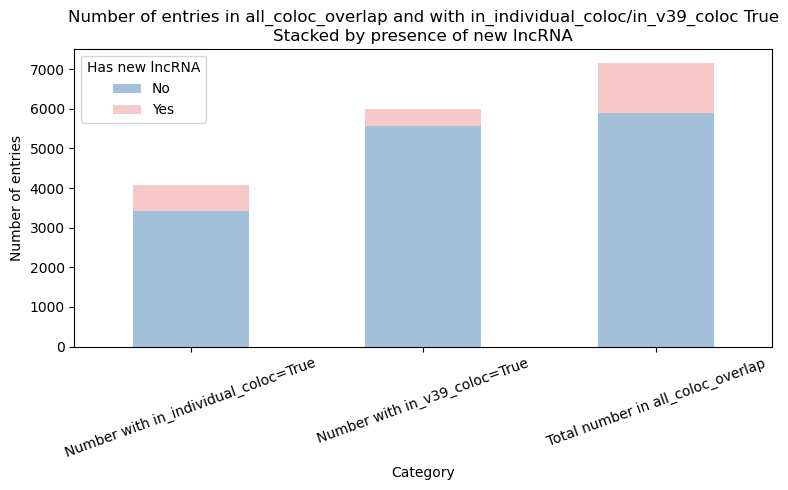

In [25]:

# Prepare data for stacked bar plot by 'has_new_lncrna'
def count_by_col_and_lnc(df, col):
    """Count number of entries with and without new lncRNA for a given boolean column."""
    subset = df[df[col]]
    return subset['has_new_lncrna'].value_counts().reindex([True, False], fill_value=0)

# Count for in_individual_coloc
indiv_counts = count_by_col_and_lnc(all_coloc_overlap, 'in_individual_coloc')
# Count for in_v39_coloc
v39_counts = count_by_col_and_lnc(all_coloc_overlap, 'in_v39_coloc')
# Count for all entries
all_counts = all_coloc_overlap['has_new_lncrna'].value_counts().reindex([True, False], fill_value=0)

# Prepare DataFrame for plotting, ensuring 'Yes' (True) comes after 'No' (False) for stacking order
bar_df = pd.DataFrame({
    'Category': ['Number with in_individual_coloc=True', 'Number with in_individual_coloc=True',
                 'Number with in_v39_coloc=True', 'Number with in_v39_coloc=True',
                 'Total number in all_coloc_overlap', 'Total number in all_coloc_overlap'],
    'Has new lncRNA': ['No', 'Yes', 'No', 'Yes', 'No', 'Yes'],
    'Count': [indiv_counts[False], indiv_counts[True],
              v39_counts[False], v39_counts[True],
              all_counts[False], all_counts[True]]
})

# Pivot for stacked bar plot
pivot_df = bar_df.pivot(index='Category', columns='Has new lncRNA', values='Count').fillna(0)
# Ensure the order: 'No' (bottom), 'Yes' (top)
pivot_df = pivot_df[['No', 'Yes']]

ax = pivot_df.plot(
    kind='bar',
    stacked=True,
    color=['#a3c1da', '#f7cac9'],
    figsize=(8, 5)
)
ax.set_ylabel('Number of entries')
ax.set_xlabel('Category')
ax.set_title('Number of entries in all_coloc_overlap and with in_individual_coloc/in_v39_coloc True\nStacked by presence of new lncRNA')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
ax.legend(title='Has new lncRNA')
plt.tight_layout()
plt.show()


In [26]:
# Collapse credible sets in individual_coloc_df into loci where any two credible sets sharing a variant are considered the same locus


# Build a graph where each node is a credible set (phenotype_ldbloc, cs_id), and edges connect sets sharing any variant
def collapse_credible_sets_to_loci(df):
    """
    Collapse credible sets into loci: any two credible sets sharing a variant are considered the same locus.
    Returns a DataFrame with one row per locus, listing all ld_block, phenotype_id, and cs_id for each locus.
    """
    # Create a unique identifier for each credible set
    df = df.copy()
    df['cs_key'] = list(zip(df['phenotype_id'], df['ld_block'], df['cs_id']))

    # Group by credible set and collect all variants for each
    cs_variants = df.groupby('cs_key')['variant_id'].apply(set)

    # Build a mapping from variant to all cs_keys containing it
    variant_to_cs = {}
    for cs_key, variants in cs_variants.items():
        for v in variants:
            variant_to_cs.setdefault(v, set()).add(cs_key)

    # Build the graph
    G = nx.Graph()
    for cs_key in cs_variants.index:
        G.add_node(cs_key)
    for variant, cs_keys in variant_to_cs.items():
        cs_keys = list(cs_keys)
        for i in range(len(cs_keys)):
            for j in range(i + 1, len(cs_keys)):
                G.add_edge(cs_keys[i], cs_keys[j])

    # Find connected components (loci)
    loci = []
    for component in nx.connected_components(G):
        ld_blocks = set()
        phenotype_ids = set()
        cs_ids = set()
        for (phenotype_id, ld_block, cs_id) in component:
            ld_blocks.add(ld_block)
            phenotype_ids.add(phenotype_id)
            cs_ids.add(cs_id)
        loci.append({
            'ld_blocks': list(ld_blocks),
            'phenotype_ids': list(phenotype_ids),
            'cs_ids': list(cs_ids)
        })

    loci_df = pd.DataFrame(loci)
    return loci_df

# Apply the function to individual_coloc_df
collapsed_loci_df = collapse_credible_sets_to_loci(individual_coloc_df)

# Show the resulting DataFrame
collapsed_loci_df.head()
# Count and print total number of unique (ld_block, cs_id) combinations in v39, all_coloc_merged, and individual_coloc_df


print(f"Total number of unique (ld_block, cs_id) combinations in all genes : {len(all_coloc_df[['ld_block', 'phenotype_id', 'cs_id']].drop_duplicates())}")
collapsed_all_df = collapse_credible_sets_to_loci(all_coloc_df)
print(f"Total number of collapsed (ld_block, cs_id) combinations in all genes: {len(collapsed_all_df)}")


print(f"Total number of unique (ld_block, cs_id) combinations in v39: {len(v39_coloc_df[['ld_block', 'phenotype_id', 'cs_id']].drop_duplicates())}")
collapsed_v39_df = collapse_credible_sets_to_loci(v39_coloc_df)
print(f"Total number of collapsed (ld_block, cs_id) combinations in v39: {len(collapsed_v39_df)}")

print(f"Total number of unique (ld_block, cs_id) combinations in individual genes: {len(individual_coloc_df[['ld_block', 'phenotype_id', 'cs_id']].drop_duplicates())}")
collapsed_individual_df = collapse_credible_sets_to_loci(individual_coloc_df)
print(f"Total number of collapsed (ld_block, cs_id) combinations in individual genes: {len(collapsed_individual_df)}")


Total number of unique (ld_block, cs_id) combinations in all genes : 7153
Total number of collapsed (ld_block, cs_id) combinations in all genes: 7054
Total number of unique (ld_block, cs_id) combinations in v39: 6371
Total number of collapsed (ld_block, cs_id) combinations in v39: 6282
Total number of unique (ld_block, cs_id) combinations in individual genes: 5166
Total number of collapsed (ld_block, cs_id) combinations in individual genes: 4274


In [29]:
# First, let's add gene type information to the collapsed DataFrames
def add_gene_types_to_collapsed_df(collapsed_df, gencode_ids):
    """
    Add gene type information to collapsed loci DataFrame by matching gene IDs from phenotype_ids.
    """
    # Create a copy to avoid modifying the original
    df = collapsed_df.copy()
    
    # Create a unique identifier for each locus
    df['locus_id'] = range(len(df))
    
    # Explode phenotype_ids to get individual gene IDs
    df_exploded = df.explode('phenotype_ids')
    
    # Split phenotype_ids to get individual gene IDs (assuming they're comma-separated)
    df_exploded['gene_id'] = df_exploded['phenotype_ids'].str.split(',')
    df_exploded = df_exploded.explode('gene_id')
    
    # Extract stable gene ID (remove version number)
    df_exploded['gene_id_stable'] = df_exploded['gene_id'].str.split('.').str[1]
    
    # Merge with gencode_ids to get gene type information
    df_with_types = df_exploded.merge(
        gencode_ids[['gene_id_stable', 'gene_type_grouped_highlight']], 
        on='gene_id_stable', 
        how='left'
    )
    
    # Group back by locus_id and collect gene types
    df_grouped = df_with_types.groupby('locus_id').agg({
        'ld_blocks': 'first',
        'phenotype_ids': 'first', 
        'cs_ids': 'first',
        'gene_type_grouped_highlight': list
    }).reset_index()
    
    # Add has_new_lncrna column
    df_grouped['has_new_lncrna'] = df_grouped['gene_type_grouped_highlight'].apply(
        lambda x: 'new_lncRNA' in x if isinstance(x, list) else False
    )
    
    # Drop the temporary locus_id column
    df_grouped = df_grouped.drop(columns=['locus_id'])
    
    return df_grouped

# Apply the function to your collapsed DataFrames
collapsed_all_df_with_types = add_gene_types_to_collapsed_df(collapsed_all_df, gencode_ids)
collapsed_v39_df_with_types = add_gene_types_to_collapsed_df(collapsed_v39_df, gencode_ids)
collapsed_individual_df_with_types = add_gene_types_to_collapsed_df(collapsed_individual_df, gencode_ids)

def count_loci_by_lnc_categories(df):
    """
    Count number of loci in three categories:
    - 'Only new lncRNA': loci where all gene types are 'new_lncRNA'
    - 'Has new lncRNA': loci with at least one 'new_lncRNA' and at least one other type
    - 'No new lncRNA': loci with no 'new_lncRNA'
    """
    def categorize(row):
        types = set(row['gene_type_grouped_highlight'])
        if types == {'new_lncRNA'}:
            return 'Only new lncRNA'
        elif 'new_lncRNA' in types:
            return 'Has new lncRNA'
        else:
            return 'No new lncRNA'
    categories = df.apply(categorize, axis=1)
    return categories.value_counts().reindex(['No new lncRNA', 'Has new lncRNA', 'Only new lncRNA'], fill_value=0)

# Count for each collapsed DataFrame
collapsed_all_counts = count_loci_by_lnc_categories(collapsed_all_df_with_types)
collapsed_v39_counts = count_loci_by_lnc_categories(collapsed_v39_df_with_types)
collapsed_indiv_counts = count_loci_by_lnc_categories(collapsed_individual_df_with_types)

In [30]:
collapsed_all_counts

No new lncRNA      5799
Has new lncRNA      978
Only new lncRNA     277
Name: count, dtype: int64

In [31]:
# Prepare DataFrame for plotting with all three lncRNA categories

# Create a DataFrame for each collapsed counts series, labeling by gene set
bar_df = pd.DataFrame({
    'Category': (['individual'] * 3) + (['joint_v39'] * 3) + (['joint_all'] * 3),
    'lncRNA category': (['No new lncRNA', 'Has new lncRNA', 'Only new lncRNA'] * 3),
    'Count': [
        collapsed_indiv_counts['No new lncRNA'],
        collapsed_indiv_counts['Has new lncRNA'],
        collapsed_indiv_counts['Only new lncRNA'],
        collapsed_v39_counts['No new lncRNA'],
        collapsed_v39_counts['Has new lncRNA'],
        collapsed_v39_counts['Only new lncRNA'],
        collapsed_all_counts['No new lncRNA'],
        collapsed_all_counts['Has new lncRNA'],
        collapsed_all_counts['Only new lncRNA'],
    ]
})

category_order = ['individual', 'joint_v39', 'joint_all']
lncrna_order = ['No new lncRNA', 'Has new lncRNA', 'Only new lncRNA']

bar_df['Category'] = pd.Categorical(bar_df['Category'], categories=category_order, ordered=True)
bar_df['lncRNA category'] = pd.Categorical(bar_df['lncRNA category'], categories=lncrna_order, ordered=True)

# Pivot for stacked bar plot
pivot_df = bar_df.pivot(index='Category', columns='lncRNA category', values='Count').fillna(0)
pivot_df = pivot_df.loc[category_order, lncrna_order]


# Define custom colors for each lncRNA category
lncrna_colors = {
    'Only new lncRNA': '#b70657',      # deep magenta
    'Has new lncRNA': '#d6a5b7',      # light pink
    'No new lncRNA': 'grey'           # grey
}
color_list = [lncrna_colors[cat] for cat in lncrna_order]

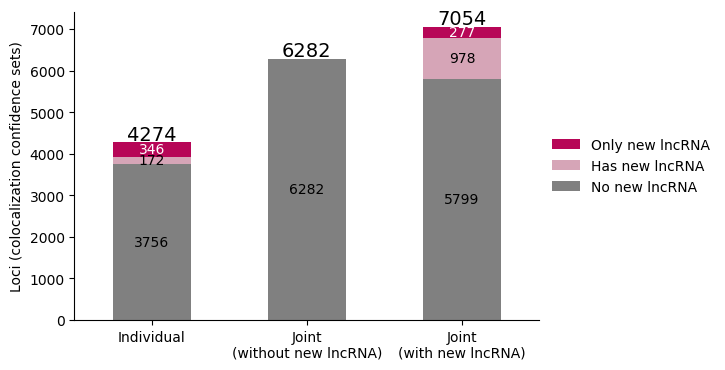

In [32]:
fig, ax = plt.subplots(figsize=(6, 4))
bars = pivot_df.plot(
    kind='bar',
    stacked=True,
    color=color_list,
    ax=ax
)


# Add bar labels for each segment in the stack if nonzero
for i, category in enumerate(category_order):
    y_offset = 0
    for j, lncrna_cat in enumerate(lncrna_order):
        count = pivot_df.loc[category, lncrna_cat]
        if count > 0:
            ax.text(
                i, 
                y_offset + count/2,
                f"{int(count)}",
                ha='center',
                va='center',
                fontsize=10,
                color='white' if lncrna_cat == 'Only new lncRNA' else 'black',
            )
        y_offset += count
    total = pivot_df.loc[category].sum()
    ax.text(
        i,
        total + max(pivot_df.max()) * 0.01,
        f"{int(total)}",
        ha='center',
        fontsize=14,
        color='black'
    )
        
ax.set_ylabel('Loci (colocalization confidence sets)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1, .5), frameon=False, title='')
ax.set_xlabel('')
ax.set_xticklabels(['Individual', 'Joint\n(without new lncRNA)', 'Joint\n(with new lncRNA)'], rotation=0)

plt.show()